<a href="https://colab.research.google.com/github/ericthansen/dsc-phase-5-project_work/blob/main/Proj5_DeepFakeID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Deepfakes (a portmanteau of "deep learning" and "fake") are an artificial image or video that replaces an existing entity with another entity's likeness.  

Creation of such media has some benign applications in art and academia, but in general, the capacity for misleading deepfakes is of great concern to public figures, media producers and distribution platforms, and individual citizens, due to its potential to be used for harmful ends.  

To combat existing and new deepfake techniques, similar visual models in deep learning can be employed to help detect deepfakes and flag them as fake.  

For this project, which uses data derived from a deepfake detection challenge on Kaggle from December 2019 (https://www.kaggle.com/competitions/deepfake-detection-challenge), we will analyze a dataset of still images extracted from deepfake and real videos.  A baseline model and an advanced hand-made model will be created, then several pretrained models will be tuned and tested.  Finally, some visual interpretability will be explored using LIME and Grad-CAM (popular interpretability approaches in Python).



Regarding choosing batch sizes and learning rate:  
These hyperparameters are vitally important but there is no magic formula for finding them.  I referred to this research:
https://www.sciencedirect.com/science/article/pii/S2405959519303455#:~:text=In%20practical%20terms%2C%20to%20determine,advantage%20of%20the%20GPUs%20processing.  
to inform some of my learning rate/batch size choices.  

# Beginning

In [1]:
# !pip install cloud_tpu_client

In [2]:
import tensorflow as tf

In [3]:
# from cloud_tpu_client import Client as ctcClient
# c = ctcClient()
# c.configure_tpu_version(tf.__version__, restart_type="always")

In [4]:
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#     print("Device:", tpu.master())
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError:
#     print("Not connected to a TPU runtime. Using CPU/GPU strategy")
#     strategy = tf.distribute.MirroredStrategy()

In [5]:
# Original competition link: https://www.kaggle.com/competitions/deepfake-detection-challenge
# Extracted images data source: https://www.kaggle.com/datasets/dagnelies/deepfake-faces


In [6]:
#Direct link hosted on my Kaggle Profile:
link = "https://www.kaggle.com/datasets/ericth/deep-fake-detection-on-faces/download?datasetVersionNumber=1"

In [163]:
## Clean up this cell before finish - was used to upload data from google drive.
##Mounting drive - only run final line to re-unzip the jpg images

from google.colab import drive 
drive.mount('/content/gdrive')

# DEEPFAKE_ARCHIVE_ZIP_PATH = '/content/gdrive/MyDrive/DataSciUploads/DeepFakeArchive/archive.zip'
# DEEPFAKE_ARCHIVE_PATH = '/content/gdrive/MyDrive/DataSciUploads/DeepFakeArchive'
DEEPFAKE_MODEL_SAVE_PATH = '/content/gdrive/MyDrive/DataSciUploads/DeepFakeArchive/models/'

#or, to avoid using google drive at all:
# !mkdir -p /content/models/
# DEEPFAKE_MODEL_SAVE_PATH =  '/content/models'




Mounted at /content/gdrive


In [8]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt
###
from keras.preprocessing.image import ImageDataGenerator
import datetime
from keras import layers
from keras import models
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from keras.callbacks import EarlyStopping

!pip install lime
from lime import lime_image

import shutil

import os
import json
import zipfile
!pip install -q kaggle
!pip install opendatasets

from google.colab import drive 

from sklearn.model_selection import train_test_split

from functools import partial
##for vgg19:
import datetime
import os, shutil
import time
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator#, array_to_img
from keras.utils import array_to_img
from keras import models
from keras import layers
from keras import optimizers
#
#for lime:
from skimage.segmentation import mark_boundaries

#for learning rate scheduling
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn import metrics

#for grad-cam
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pathlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=727263490198fb1eabd4bcbfc328423f64b60977d1e413a389a2e9fc4d77cfda
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [10]:
import os

The following sets up access to the kaggle download from the Colab or Jupyter notebook.  If you have kaggle token, use it below.  If you don't have one, follow the links below.

In [11]:
##DELETE THE HARDCODED username and key before final release!
#import kaggle package
!pip install -q kaggle


In [12]:
# !pip install kaggle
# api_token = {"username":"username","key":"TOKEN_HERE"}
# import json
# import zipfile
# import os
# with open('/root/.kaggle/kaggle.json', 'w') as file:
#     json.dump(api_token, file)
# !kaggle datasets download -d iarunava/happy-house-dataset

In [13]:
#this works in a pinch - it doesn't use the opendatasets so it's not as clean but it is clear what is happening.

# %%capture
# import os
# os.environ['KAGGLE_USERNAME'] = "ericth"
# os.environ['KAGGLE_KEY'] = "0d9ce7ee427dd62e5f39c1190e358d0c"
# !kaggle datasets download -d 'ericth/deep-fake-detection-on-faces/download?datasetVersionNumber=1'
# !unzip deep-fake-detection-on-faces.zip -d deep-fake-detection-on-faces

In [14]:
#currently I don't think this will be used.

# #!mkdir -p /content/.kaggle
# !mkdir -p ~/.kaggle
# !echo '{"username":"ericth","key":"0d9ce7ee427dd62e5f39c1190e358d0c"}' > ~/.kaggle/kaggle.json

# #!kaggle datasets download -d owner/dataset-slug

In [15]:
#Importing colab file handling
from google.colab import files
#files.upload()
#necessary to upload YOUR kaggle token here.  If you need a kaggle token, follow these instructions:
# https://github.com/Kaggle/kaggle-api#api-credentials

#Or, if you prefer to hardcode your token for repeated use:
##https://gist.github.com/jayspeidell/d10b84b8d3da52df723beacc5b15cb27


In [16]:
##keep and uncomment this for final release!!!!!
# interacting with kaggle.json API key, depending if you want hardcoded key or to upload your json key file each run.
HARDCODEDKEY = True

if HARDCODEDKEY:
  api_token = {"username":"ericth","key":"0d9ce7ee427dd62e5f39c1190e358d0c"}
  import json
  #import zipfile
  import os
  
  #!mkdir -p /root/.kaggle/
  with open('/content/kaggle.json', 'w') as file:
      json.dump(api_token, file)
  #!kaggle config path -p /content
  #!ls -lha /root/.kaggle/kaggle.json
  !chmod 600 /content/kaggle.json
  #!kaggle config path -p /content

else:
  files.upload()
  # !ls -lha kaggle.json
  # !pip install -q kaggle # installing the kaggle package
  # !mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
  # !cp kaggle.json ~/.kaggle/ # move the key to the folder
  !chmod 600 /root/.kaggle/kaggle.json
  !pwd # checking the present working directory

In [17]:
##don't need this, but can uncomment it to check if kaggle token setup is working
#!chmod 600 /root/.kaggle/kaggle.json
!chmod 600 /content/kaggle.json
#!kaggle datasets list

In [18]:
#using opendatasets in order to get the kaggle data archive file.
!pip install opendatasets
import opendatasets as od
od.download(link)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|██████████| 433M/433M [00:03<00:00, 129MB/s]


At this point, the data archive zip file hosted on kaggle should be available in Content/ in Colab

In [19]:
colab_link = '/content/deep-fake-detection-on-faces/'

In [20]:
#For reference, can DELETE!!!
# #GloVe Set-up - 
# # 0) Acquire glove zipped file and put on google drive to use with Colab

# # 1) unzip
# ##only run the following lines once!
# from google.colab import drive
# drive.mount('/content/gdrive')
# #### !unzip gdrive/My\ Drive/DataSciUploads/GloVe/glove.840B.300d.zip


# # 2) make file available
# #GLOVE_PATH = '/content/gdrive/MyDrive/DataSciUploads/GloVe/glove.840B.300d.txt'
# GLOVE_PATH = '/content/gdrive/MyDrive/DataSciUploads/GloVe/glove.6B.300d.txt'


In [21]:
# probably remove this comment
#this is necessary sometimes to rerun; it appears perhaps as though files get corrupted on google drive?  is this possible?
#!unzip -u '/content/gdrive/MyDrive/DataSciUploads/DeepFakeArchive/archive.zip' -d '/content/gdrive/MyDrive/DataSciUploads/DeepFakeArchive'

In [22]:
#DF_AP_FACES = DEEPFAKE_ARCHIVE_PATH+'/faces_224/'

In [23]:
# images we are working with have been scaled to uniform 224x224x3.  Make this accessible for later
input_shape = [224, 224, 3]
image_size = input_shape[0]
img2dim = (224, 224)
IMG_SHAPE = (224, 224, 3)
IMG_SIZE = image_size
NUM_CLASSES = 2

In [24]:
#Establish random seed and a "summarize" flag 
RANDOM_SEED = 42
SUMMARIZE = False #if true, will give more output from model tuning and exploration

#Make a flag to save files to Google Drive - will want to make this false for release version.
DRIVE_SAVE = True

In [25]:
# checking tensorflow on Google Colab - can probably Delete!
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  pass
  #raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [26]:
#MOVE TO SETUP - DO WE WANT A TPU?
# from cloud_tpu_client import Client
# c = Client()
# c.configure_tpu_version(tf.__version__, restart_type="always")

In [27]:
# import tensorflow as tf

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#     print("Device:", tpu.master())
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError:
#     print("Not connected to a TPU runtime. Using CPU/GPU strategy")
#     strategy = tf.distribute.MirroredStrategy()

In [28]:
# it is necessary to clear the keras backend periodically
tf.keras.backend.clear_session()

In [29]:
# ##Not necessary to run every time - just a check on GPU performance
# # testing GPU speedup
# %tensorflow_version 2.x
# import tensorflow as tf
# import timeit

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#   raise SystemError('GPU device not found')

# def cpu():
#   with tf.device('/cpu:0'):
#     random_image_cpu = tf.random.normal((100, 100, 100, 3))
#     net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
#     return tf.math.reduce_sum(net_cpu)

# def gpu():
#   with tf.device('/device:GPU:0'):
#     random_image_gpu = tf.random.normal((100, 100, 100, 3))
#     net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
#     return tf.math.reduce_sum(net_gpu)
  
# # We run each op once to warm up; see: https://stackoverflow.com/a/45067900
# cpu()
# gpu()

# # Run the op several times.
# print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
#       '(batch x height x width x channel). Sum of ten runs.')
# print('CPU (s):')
# cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
# print(cpu_time)
# print('GPU (s):')
# gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
# print(gpu_time)
# print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

In [30]:
#!pip install -U --upgrade tensorflow




# EDA - I

In [31]:
# data archive comes with a metadata file that has labels for real/fake status
meta=pd.read_csv('/content/deep-fake-detection-on-faces/metadata.csv')
meta.head()

videoname  original_width  original_height label        original
0  aznyksihgl.mp4             129              129  FAKE  xnojggkrxt.mp4
1  gkwmalrvcj.mp4             129              129  FAKE  hqqmtxvbjj.mp4
2  lxnqzocgaq.mp4             223              217  FAKE  xjzkfqddyk.mp4
3  itsbtrrelv.mp4             186              186  FAKE  kqvepwqxfe.mp4
4  ddvgrczjno.mp4             155              155  FAKE  pluadmqqta.mp4

In [32]:
meta.shape

(95634, 5)

In [33]:
meta.describe()

original_width  original_height
count    95634.000000     95634.000000
mean       164.611174       164.565374
std         60.002852        60.011802
min         36.000000        36.000000
25%        108.000000       107.000000
50%        155.000000       155.000000
75%        223.000000       223.000000
max        665.000000       666.000000

In [34]:
# it's not actually of concern that "original" is NA, since we won't use it.
meta.isna().sum()

videoname              0
original_width         0
original_height        0
label                  0
original           16293
dtype: int64

In [35]:
#check number of fake and real images in the dataset
len(meta[meta.label=='FAKE']),len(meta[meta.label=='REAL'])

(79341, 16293)

Since there are only just over 16K Real images (and many more Fake ones), we will limit (at the start at least) the analysis to just 32K total images to achieve equal set distribution.

In [36]:
# pull random samples 
#update sample_size as necessary!!!
sample_size = 16000

real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]


real_df = real_df.sample(sample_size, random_state=RANDOM_SEED)
fake_df = fake_df.sample(sample_size, random_state=RANDOM_SEED)

sample_meta = pd.concat([real_df, fake_df])

In [37]:
# train/test/validation split - at this point, just a list of filenames
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=RANDOM_SEED,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=RANDOM_SEED,stratify=Train_set['label'])

In [38]:
#add a column to metadata file to refer to the current .jpg file name for the images.
def make_jpg_filename_col(set_in):
  set_out = set_in.assign(jpg_filename = lambda x: (x['videoname'].str[:-4]+'.jpg'))
  return set_out

Train_set = make_jpg_filename_col(Train_set)
Val_set = make_jpg_filename_col(Val_set)
Test_set = make_jpg_filename_col(Test_set)


Current workaround attempt - copy file from google drive to colab local

this has now been reworked to be a download into colab directly from kaggle.

In [39]:
#!mkdir "/content/deepfake_files/"

In [40]:
#shutil.copy("/content/gdrive/MyDrive/DataSciUploads/DeepFakeArchive/archive.zip", "/content/deepfake_files/archive.zip")
#shutil.copy("/content/deepfake_files/archiveBAK.zip", "/content/gdrive/MyDrive/DataSciUploads/DeepFakeArchive/archive.zip")

In [41]:
#!unzip -u '/content/deepfake_files/archive.zip' -d '/content/deepfake_files/archive/'

In [42]:
####colab_link = "/content/deepfake_files/archive/"

#set up colab_faces directory to access the images
colab_faces = colab_link+"faces_224/"

In [43]:
#check shape of sets
Train_set.shape,Val_set.shape,Test_set.shape

((17920, 6), (7680, 6), (6400, 6))

In [44]:
# Visualize the different sets sizes
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)

In [45]:
Train_set.head()

videoname  original_width  original_height label        original  \
25257  xzlqysylfv.mp4              89               90  FAKE  uztrloeuqh.mp4   
81650  bigruojxrp.mp4             186              186  REAL             NaN   
62786  glzgcpyqwy.mp4              90               90  FAKE  tcbkjjwzcr.mp4   
41861  lmyaqrdaka.mp4             107              107  REAL             NaN   
84016  vlijwlulnz.mp4             155              155  REAL             NaN   

         jpg_filename  
25257  xzlqysylfv.jpg  
81650  bigruojxrp.jpg  
62786  glzgcpyqwy.jpg  
41861  lmyaqrdaka.jpg  
84016  vlijwlulnz.jpg

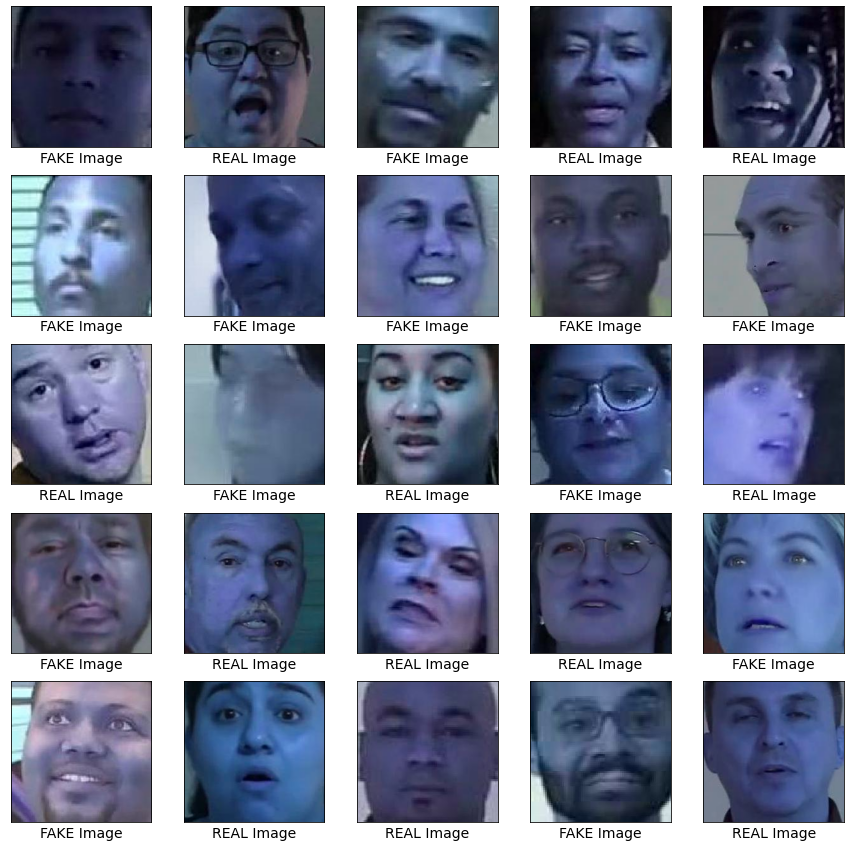

In [46]:
# visualize a small selection of some of the images
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[:25]):
    #print(i)
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(cv2.imread(colab_link+'/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))
    
    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

# Baseline model setup  

In [47]:
def report_acc(model):
  # quick summary of model accuracies - warning - must be run just after apprpriate generator.n and batch sizes are computed
  train_loss, train_accuracy = base_model.evaluate(train_generator, steps=numpy.ceil(train_generator.n / batch_size))
  print('train acc:', train_accuracy)
  val_loss, val_accuracy = base_model.evaluate(val_generator, steps=numpy.ceil(val_generator.n / batch_size))
  print('val acc:', val_accuracy)
  test_loss, test_accuracy = base_model.evaluate(test_generator, steps=numpy.ceil(test_generator.n / batch_size))
  print('test acc:', test_accuracy)

First, create train/test sets and labels.  Training data is already taken care of, but labels must be pulled in from the metadata file.

In [48]:
def retrieve_dataset(set_name):
    '''based on set(train/test/val) name, append the raw image data to a numpy array for processing'''
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        # if img[0]=='a':
        #   print(img)
        #   display(cv2.imread(colab_faces+img[:-4]+'.jpg'))
        images.append(cv2.imread(colab_faces+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images),np.array(labels)

In [49]:
#create train/test/val sets with raw data
X_train,y_train=retrieve_dataset(Train_set)
X_val,y_val=retrieve_dataset(Val_set)
X_test,y_test=retrieve_dataset(Test_set)

In [50]:
  # plot model performance
def plot_perf(history):
    '''plot loss and accuracy over training epochs'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(history.epoch) + 1)

    plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Set')
    plt.plot(epochs_range, val_acc, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Set')
    plt.plot(epochs_range, val_loss, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()

# Baseline model begin

In [ ]:
# create a simple baseline model; using convolutional nets
from functools import partial

tf.random.set_seed(RANDOM_SEED) 
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 401408)            0

In [ ]:
history = model.fit(X_train, y_train, epochs=5,batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/10
280/280 [==============================] - 117s 374ms/step - loss: 53.7460 - accuracy: 0.4968 - val_loss: 0.6935 - val_accuracy: 0.4892
Epoch 2/10
280/280 [==============================] - 105s 374ms/step - loss: 0.6942 - accuracy: 0.5030 - val_loss: 0.6932 - val_accuracy: 0.5003
Epoch 3/10
280/280 [==============================] - 106s 377ms/step - loss: 0.7931 - accuracy: 0.5017 - val_loss: 0.6930 - val_accuracy: 0.5087
Epoch 4/10
280/280 [==============================] - 106s 378ms/step - loss: 0.6944 - accuracy: 0.5012 - val_loss: 0.6929 - val_accuracy: 0.5016
Epoch 5/10
280/280 [==============================] - 106s 378ms/step - loss: 0.6935 - accuracy: 0.5009 - val_loss: 0.6930 - val_accuracy: 0.5021
Epoch 6/10
280/280 [==============================] - 106s 379ms/step - loss: 0.6931 - accuracy: 0.4978 - val_loss: 0.6928 - val_accuracy: 0.4996
Epoch 7/10
280/280 [==============================] - 106s 379ms/step - loss: 0.6925 - accuracy: 0.5085 - val_loss: 0.6926 

In [ ]:
score = model.evaluate(X_test, y_test)

200/200 [==============================] - 14s 64ms/step - loss: 0.6932 - accuracy: 0.4989


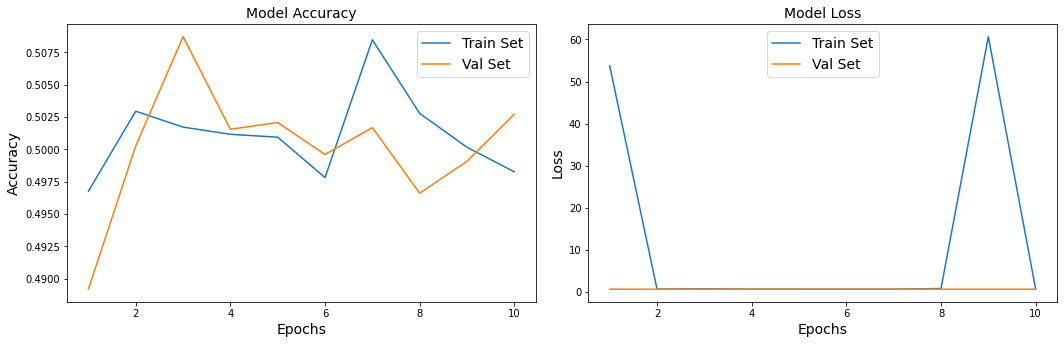

In [ ]:
plot_perf(history)

In [ ]:
if DRIVE_SAVE:
  model.save(DEEPFAKE_MODEL_SAVE_PATH+'baseline_CNN')
# from tensorflow import keras
# model = keras.models.load_model(DEEPFAKE_MODEL_SAVE_PATH+'baseline_CNN')

Okay, so we have a baseline model which has ~50% accuracy, we can go from here.

## Baseline Model - upgraded

In [113]:
tf.keras.backend.clear_session() 

Let's attempt a slightly more sophisticated manually-designed model patterned after XCeption.

In [114]:
#make data into dataset format
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [115]:
batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=RANDOM_SEED).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

In [116]:
#First, create data augmentation layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=img2dim + (3,),),
        layers.RandomRotation(0.1),
    ],
    
)

In [117]:
#First, create data augmentation layer
data_aug_default = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

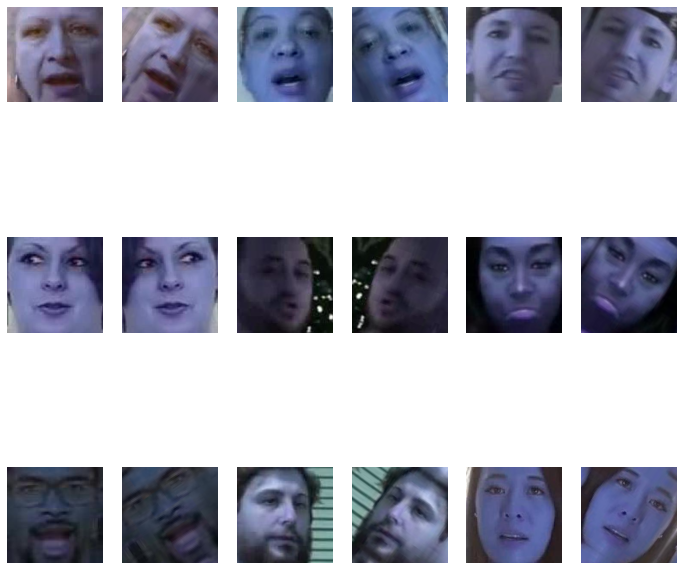

In [118]:

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 6, 2*index + 1)
        img = (X_batch[index] + 1) / 2
        plt.imshow(img)  # rescale to 0–1 for imshow()
        plt.axis("off")
        img = data_aug_default(img)
        plt.subplot(3, 6, 2*index + 2)
        plt.imshow(img)  # rescale to 0–1 for imshow()
        # if(y_batch[index]==1):
        #     classt='FAKE'
        # else:
        #     classt='REAL'
        # plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

These images have acquired a blue tint.  This is an effect of using imshow on them, which is necessary to use in plt.  
To get a normal representation, we can use below.  
Do note that these images aren't processed in an abnormal way that turns them blue and skews the data in some way.

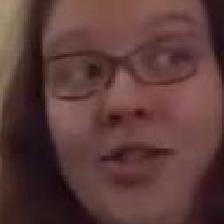

In [182]:
#try a different way to display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pathlib
img_path = pathlib.Path(colab_link+'/faces_224/'+'gkwmalrvcj.jpg') 

display(Image(img_path))

In [122]:
# set up prefetching 

# train_ds = train_set.map(
#     lambda img, label: (data_augmentation(img), label),
#     num_parallel_calls=tf.data.AUTOTUNE,
# )
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_set.prefetch(tf.data.AUTOTUNE)
val_ds = valid_set.prefetch(tf.data.AUTOTUNE)
test_ds = test_set.prefetch(tf.data.AUTOTUNE)

In [121]:
for X_batch, y_batch in train_ds.take(1):
  print(y_batch[3])
  #print(X_batch[3])

tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
# for X_batch, y_batch in val_ds.take(1):
#   print(y_batch[3])
#   print(X_batch[3])

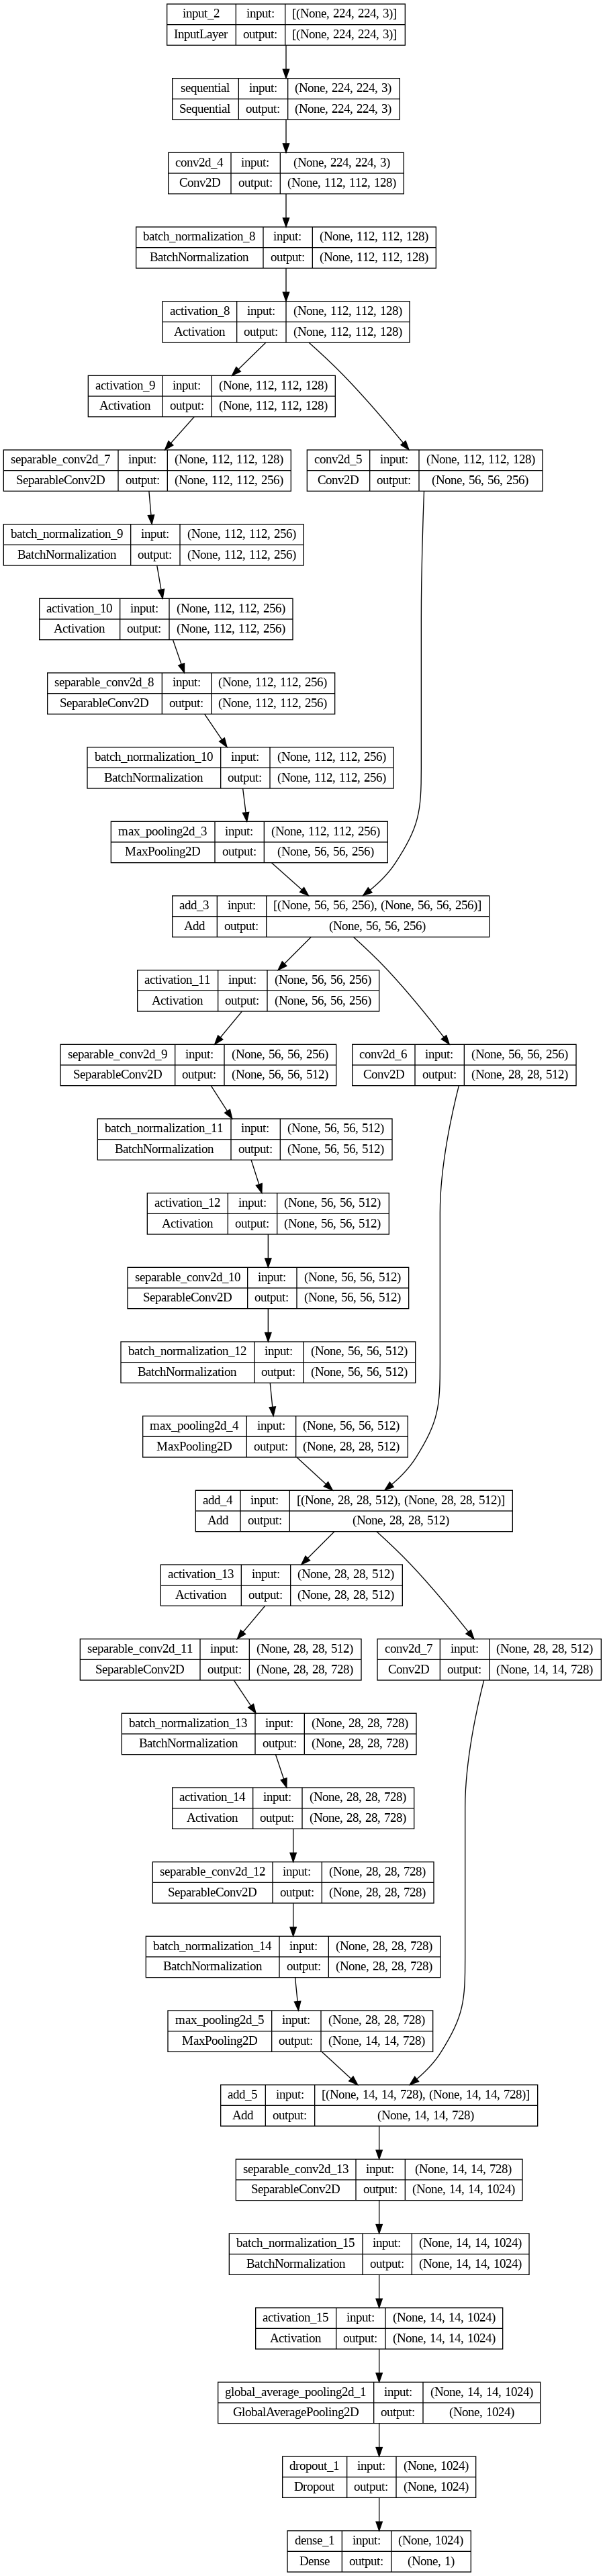

In [ ]:
# set up slightly enhanced baseline model
# based on https://keras.io/examples/vision/image_classification_from_scratch/
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = data_augmentation(inputs)
    #x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

# img2dim = (224, 224)

model = make_model(input_shape=img2dim + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

Train the model

In [ ]:
#this appears to take 20 minutes per epoch. something is wrong.
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
560/560 [==============================] - 181s 320ms/step - loss: 0.7102 - accuracy: 0.5664 - val_loss: 0.7077 - val_accuracy: 0.5070
Epoch 2/25
560/560 [==============================] - 182s 326ms/step - loss: 0.6788 - accuracy: 0.5973 - val_loss: 0.6996 - val_accuracy: 0.5841
Epoch 3/25
560/560 [==============================] - 183s 327ms/step - loss: 0.6557 - accuracy: 0.6188 - val_loss: 0.7455 - val_accuracy: 0.5814
Epoch 4/25
560/560 [==============================] - 181s 323ms/step - loss: 0.6455 - accuracy: 0.6317 - val_loss: 0.6623 - val_accuracy: 0.6076
Epoch 5/25
560/560 [==============================] - 182s 325ms/step - loss: 0.6289 - accuracy: 0.6527 - val_loss: 0.6520 - val_accuracy: 0.6172
Epoch 6/25
560/560 [==============================] - 183s 328ms/step - loss: 0.6172 - accuracy: 0.6585 - val_loss: 0.6106 - val_accuracy: 0.6600
Epoch 7/25
560/560 [==============================] - 182s 324ms/step - loss: 0.6049 - accuracy: 0.6763 - val_loss: 0.6618 -

In [ ]:
if DRIVE_SAVE:
  model.save(DEEPFAKE_MODEL_SAVE_PATH+'baseline_plus1_2_23')

In [ ]:
from tensorflow import keras
model = keras.models.load_model(DEEPFAKE_MODEL_SAVE_PATH+'baseline_plus1_2_23')

Now, graphs and performance

In [ ]:
plot_perf(hist)

### Fix here

In [ ]:
#plot confusion matrix
actual=[]
for images, labels in test_ds.unbatch():
    actual.append(labels.numpy())

predicted = np.where(model.predict(test_ds)>0.5, 1, 0)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted)

# cm_display.plot()
plt.show()

In [ ]:
model.evaluate(test_ds)

200/200 [==============================] - 5s 23ms/step - loss: 0.4810 - accuracy: 0.7673


[0.48098841309547424, 0.7673437595367432]

In [ ]:
print(f'Test set Accuracy: {(2156+2755)/6400}') # based on hardcoded confusion matrix

Test set Accuracy: 0.76734375


# Pretrained models

As mentioned in lessons, there are several pretrained models which can be good starting points for these types of tasks. 
Keras documentation performance can be found here:  
https://keras.io/api/applications/  


## VGG19


In [52]:
tf.keras.backend.clear_session() #good to clear session between models

In [53]:
startp = datetime.datetime.now() #For timing of process

In [54]:
#vgg19 imports; loaded at top but reloaded in case starting with this model
import datetime

start = datetime.datetime.now()
#
import os, shutil
import time
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator#, array_to_img
#tf.keras.utils.array_to_img(
from keras.utils import array_to_img

from keras import models
from keras import layers
from keras import optimizers

np.random.seed(RANDOM_SEED)

#
train_folder = 'split/train'
test_folder = 'split/test'
val_folder = 'split/validation'
#
datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 10
##vgg19 feature extraction
from tensorflow.keras.applications import VGG19
cnn_base = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(64, 64, 3))
                 #input_shape=(224, 224, 3)) #turn this on if include_top=True
    
#
if SUMMARIZE:
  cnn_base.summary()
##


80134624/80134624 [==============================] - 0s 0us/step


Set up base model with customized final layers


In [55]:
#Use VGG19 as base model, add final layers on top for our categorization purposes
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(132, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

for layer in model.layers:
    print(layer.name, layer.trainable)

##freezing
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(model.trainable_weights))

#
print("Setting base layers to non-trainable")
cnn_base.trainable = False
##check
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(model.trainable_weights))



vgg19 True
flatten True
dense True
dense_1 True
vgg19 True
flatten True
dense True
dense_1 True
36
Setting base layers to non-trainable
vgg19 False
flatten True
dense True
dense_1 True
4


In [56]:
#Doublecheck train_set info
Train_set.info()
Train_set.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17920 entries, 25257 to 91352
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   videoname        17920 non-null  object
 1   original_width   17920 non-null  int64 
 2   original_height  17920 non-null  int64 
 3   label            17920 non-null  object
 4   original         8960 non-null   object
 5   jpg_filename     17920 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.5+ MB


videoname             0
original_width        0
original_height       0
label                 0
original           8960
jpg_filename          0
dtype: int64

Set up ImageDataGenerators to create extra samples.  

In [57]:
# Set up ImageDataGenerators in order to build out more samples for training.
startp = datetime.datetime.now()
#
# Get all the data in the directory split/train, and reshape them
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(dataframe=pd.DataFrame(Train_set), 
                                                    x_col='jpg_filename', y_col='label', 
                                                    directory=colab_faces,
                                                    target_size=(64, 64),  
                                                    batch_size= 20, 
                                                    class_mode= 'binary')
# # Get all the data in the directory split/validation (200 images), and reshape them
val_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')
val_generator = val_datagen.flow_from_dataframe(dataframe=pd.DataFrame(Val_set), 
                                                    x_col='jpg_filename', y_col='label', 
                                                    directory=colab_faces,
                                                    target_size=(64, 64),  
                                                    batch_size= 20, 
                                                    class_mode= 'binary')

# # Get all the data in the directory split/test (180 images), and reshape them
test_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')
test_generator = test_datagen.flow_from_dataframe(dataframe=pd.DataFrame(Test_set), 
                                                    x_col='jpg_filename', y_col='label', 
                                                    directory=colab_faces,
                                                    target_size=(64, 64),  
                                                    batch_size= 20, 
                                                    class_mode= 'binary',
                                                    shuffle=False)

test_images, test_labels = next(test_generator)


Found 17920 validated image filenames belonging to 2 classes.
Found 7680 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.


Freeze the base model and compile and train the untrained top layers.

Epoch 1/20
280/280 [==============================] - 26s 61ms/step - loss: 0.7379 - acc: 0.5470 - val_loss: 0.6786 - val_acc: 0.5704
Epoch 2/20
280/280 [==============================] - 17s 60ms/step - loss: 0.6779 - acc: 0.5786 - val_loss: 0.6826 - val_acc: 0.5867
Epoch 3/20
280/280 [==============================] - 17s 60ms/step - loss: 0.6740 - acc: 0.5770 - val_loss: 0.6661 - val_acc: 0.5938
Epoch 4/20
280/280 [==============================] - 17s 60ms/step - loss: 0.6642 - acc: 0.6050 - val_loss: 0.6582 - val_acc: 0.6204
Epoch 5/20
280/280 [==============================] - 17s 61ms/step - loss: 0.6692 - acc: 0.5932 - val_loss: 0.6649 - val_acc: 0.6067
Epoch 6/20
280/280 [==============================] - 17s 60ms/step - loss: 0.6653 - acc: 0.5943 - val_loss: 0.6651 - val_acc: 0.5913
Epoch 7/20
280/280 [==============================] - 17s 60ms/step - loss: 0.6653 - acc: 0.6037 - val_loss: 0.6688 - val_acc: 0.5817
Epoch 8/20
280/280 [==============================] - 17s 60ms

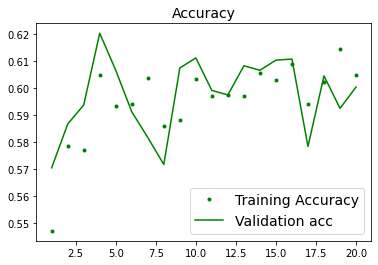

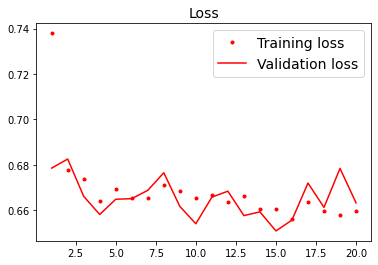

Feature extraction method 2 took 0:05:46.024945 to execute.
Total running time of notebook thus far: 0:05:47.975673
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 132)               270468    
                                                                 
 dense_1 (Dense)             (None, 1)                 133       
                                                                 
Total params: 20,294,985
Trainable params: 270,601
Non-trainable params: 20,024,384
_________________________________________________________________


In [58]:
##compile as usual
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-3),
              metrics=['acc'])

##and fit the model
# ⏰ This cell may take several minutes to run
batch_size = 64
steps_per_epoch = np.ceil(train_generator.n / batch_size)
validation_steps = np.ceil(val_generator.n / batch_size)
history = model.fit(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=20,
                              validation_data=val_generator,
                              validation_steps=validation_steps)

##
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()
##
end = datetime.datetime.now()
elapsed = end - startp
print('Feature extraction method 2 took {} to execute.'.format(elapsed))
elapsed = end - start
print('Total running time of notebook thus far: {}'.format(elapsed))
startp = datetime.datetime.now() # Set new start time for new process method
##
##fine tuning
model.summary()


In [61]:
if DRIVE_SAVE:
  model.save(DEEPFAKE_MODEL_SAVE_PATH+'VGG19_TransferLearning_halfway')
#model = keras.models.load_model(DEEPFAKE_MODEL_SAVE_PATH+'VGG19_TransferLearning_halfway')

Now, unfreeze the base model layers and train at a lower learning rate

In [62]:
for layer in model.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten True
dense True
dense_1 True


Setting base to trainable
Epoch 1/20
280/280 [==============================] - 20s 62ms/step - loss: 0.7180 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5038
Epoch 2/20
280/280 [==============================] - 17s 61ms/step - loss: 0.6951 - accuracy: 0.5225 - val_loss: 0.6817 - val_accuracy: 0.5592
Epoch 3/20
280/280 [==============================] - 17s 61ms/step - loss: 0.6939 - accuracy: 0.5564 - val_loss: 0.6735 - val_accuracy: 0.5929
Epoch 4/20
280/280 [==============================] - 17s 61ms/step - loss: 0.6757 - accuracy: 0.5866 - val_loss: 0.6793 - val_accuracy: 0.5633
Epoch 5/20
280/280 [==============================] - 17s 61ms/step - loss: 0.6778 - accuracy: 0.5807 - val_loss: 0.6686 - val_accuracy: 0.5867
Epoch 6/20
280/280 [==============================] - 17s 60ms/step - loss: 0.6712 - accuracy: 0.5889 - val_loss: 0.6577 - val_accuracy: 0.6150
Epoch 7/20
280/280 [==============================] - 17s 60ms/step - loss: 0.6622 - accuracy: 0.6016 - val_lo

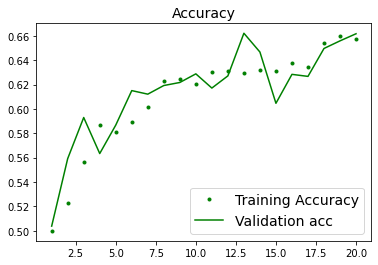

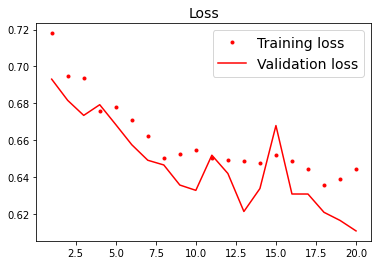

50/50 [==============================] - 2s 42ms/step - loss: 0.6120 - accuracy: 0.6620
test acc: 0.6620000004768372


In [63]:
## Now, unfreeze the base model layers and train at a lower learning rate
#
if SUMMARIZE:
  model.summary()
##reminder on fine tuning - feature extraction comes first.  then train final layers, then unfreeze last few layers by unfreezing
#entire thing and then refreezing beginning layers
cnn_base.trainable = True
print("Setting base to trainable")
if SUMMARIZE:
  model.summary()
set_trainable = True
for layer in cnn_base.layers:
    # if layer.name == 'block5_conv1':
    #     set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
##recompile
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(learning_rate=1e-4), 
              metrics=['accuracy'])

##fit
# ⏰ This cell may take several minutes to run
steps_per_epoch = np.ceil(train_generator.n / batch_size)
validation_steps = np.ceil(val_generator.n / batch_size)
history = model.fit(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=20,
                              validation_data=val_generator,
                              validation_steps=validation_steps)
##
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()
##final eval on test set

test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print('test acc:', test_accuracy)

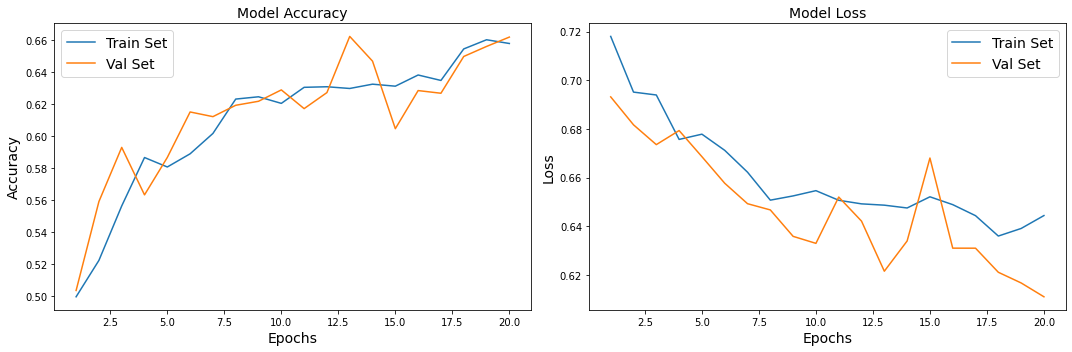

In [64]:
# plot model performance
plot_perf(history)

In [65]:
if DRIVE_SAVE:
  model.save(DEEPFAKE_MODEL_SAVE_PATH+'VGG19_TransferLearning_1')
# from tensorflow import keras
# model = keras.models.load_model(DEEPFAKE_MODEL_SAVE_PATH+'VGG19_TransferLearning_1')

In [66]:
#Loading in for testing of confusion matrix only
# from tensorflow import keras
# model = keras.models.load_model(DEEPFAKE_MODEL_SAVE_PATH+'VGG19_TransferLearning_1')

In [68]:
model.evaluate(test_generator)

320/320 [==============================] - 14s 42ms/step - loss: 0.6076 - accuracy: 0.6686


[0.6076242923736572, 0.6685937643051147]

320/320 [==============================] - 14s 43ms/step


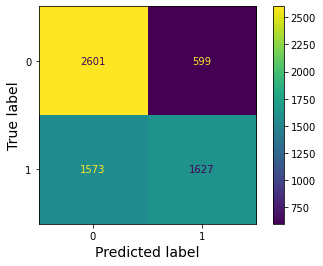

In [70]:
actual = test_generator.labels
predicted = np.where(model.predict(test_generator)>0.5, 1, 0)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted)

# cm_display.plot()
plt.show()

## MobileNet

Let's continue with something with lower run-time like ...MobileNet!

In [ ]:
tf.keras.backend.clear_session() #good to clear session between models

In [ ]:
startp = datetime.datetime.now() #for timing of process

In [ ]:
#reference code for early stopping:
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto')
# model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=30, 
#           verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Set up data generation for extra samples

In [ ]:
# Let's start with something with lower run-time like ...MobileNet!
startp = datetime.datetime.now()

input_shape=[224, 224, 3]
image_size = 224
img_size = (224, 224)
#re-import in case we are starting from this model
import os
import tensorflow as tf
from tensorflow import keras
import numpy
#end re-import

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest'
                                   )

train_generator = train_datagen.flow_from_dataframe(dataframe=pd.DataFrame(Train_set), 
                                                    x_col='jpg_filename', y_col='label', 
                                                    directory=colab_faces,
                                                    target_size=(image_size, image_size),  
                                                    batch_size= 20, 
                                                    class_mode= 'binary')
# # Get all the data in the directory split/validation (200 images), and reshape them
val_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest'
                                   )
val_generator = val_datagen.flow_from_dataframe(dataframe=pd.DataFrame(Val_set), 
                                                    x_col='jpg_filename', y_col='label', 
                                                    directory=colab_faces,
                                                    target_size=(image_size, image_size),  
                                                    batch_size= 20, 
                                                    class_mode= 'binary')

# # Get all the data in the directory split/test (180 images), and reshape them
test_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest'
                                   )
test_generator = test_datagen.flow_from_dataframe(dataframe=pd.DataFrame(Test_set), 
                                                    x_col='jpg_filename', y_col='label', 
                                                    directory=colab_faces,
                                                    target_size=(image_size, image_size),  
                                                    batch_size= 20, 
                                                    class_mode= 'binary', shuffle=False)

Found 17920 validated image filenames belonging to 2 classes.
Found 7680 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.


Inspect initial base model.  We will need to remove final layers of base model to customize them for our purpose.

In [ ]:
#inspecting base model

base_model = tf.keras.applications.MobileNet()
if SUMMARIZE:
  base_model.summary()

17225924/17225924 [==============================] - 0s 0us/step


Remove existing top layer of base model and inspect.

In [ ]:

base_model = tf.keras.applications.MobileNet(input_shape=input_shape, include_top=False)
base_model.trainable = False
#include_top removes top layer

if SUMMARIZE:
    base_model.summary()

17225924/17225924 [==============================] - 0s 0us/step


Now create the desired model, consisting of base model (without top layer) joined with our desired output layer.

In [ ]:
#adding new dense layers - add final layer that classifies either as fake or real
IMG_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, include_top=False)
base_model.trainable = False

base_model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])
if SUMMARIZE:
  base_model.summary()

#these new layers should be trainable by default, but can switch trainability by
# base_model.layers[n].trainable = True


In [ ]:
# Compile the model
# use learning rate that is comparatively higher for training just the top layers.
learning_rate=1E-2
base_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#check size of generators - we will divide this by batch size
display(train_generator.n)
val_generator.n

17920

7680

In [ ]:
#Fit the model
epochs = 20
batch_size = 32 ##REVISIT THIS - can improve this accuracy 
steps_per_epoch = numpy.ceil(train_generator.n / batch_size)
validation_steps = numpy.ceil(val_generator.n / batch_size)

history = base_model.fit(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=validation_steps)

##need to train top layer with high learning rate, then unfreeze base and retrain with lower LR.



Epoch 1/20
560/560 [==============================] - 204s 361ms/step - loss: 1.1477 - accuracy: 0.5653 - val_loss: 1.9177 - val_accuracy: 0.5044
Epoch 2/20
560/560 [==============================] - 198s 353ms/step - loss: 1.0984 - accuracy: 0.5835 - val_loss: 1.3470 - val_accuracy: 0.5465
Epoch 3/20
560/560 [==============================] - 195s 349ms/step - loss: 1.0825 - accuracy: 0.6019 - val_loss: 0.8807 - val_accuracy: 0.6327
Epoch 4/20
560/560 [==============================] - 195s 348ms/step - loss: 1.0934 - accuracy: 0.6001 - val_loss: 0.9261 - val_accuracy: 0.5990
Epoch 5/20
560/560 [==============================] - 197s 352ms/step - loss: 1.0985 - accuracy: 0.5943 - val_loss: 1.3385 - val_accuracy: 0.5431
Epoch 6/20
560/560 [==============================] - 196s 350ms/step - loss: 1.0849 - accuracy: 0.6006 - val_loss: 0.7498 - val_accuracy: 0.6490
Epoch 7/20
560/560 [==============================] - 196s 350ms/step - loss: 1.0639 - accuracy: 0.6104 - val_loss: 1.0802 -

In [ ]:
if DRIVE_SAVE:
  base_model.save(DEEPFAKE_MODEL_SAVE_PATH+'MobileNet_halfway')
# from tensorflow import keras
# model = keras.models.load_model(DEEPFAKE_MODEL_SAVE_PATH+'MobileNet_halfway')

In [ ]:
train_loss, train_accuracy = base_model.evaluate(train_generator, steps=steps_per_epoch)
print('train acc:', train_accuracy)

560/560 [==============================] - 152s 272ms/step - loss: 0.7755 - accuracy: 0.6439
train acc: 0.643928587436676


In [ ]:
val_loss, val_accuracy = base_model.evaluate(val_generator, steps=validation_steps)
print('val acc:', val_accuracy)

162/240 [===================>..........] - ETA: 21s - loss: 0.7956 - accuracy: 0.6506

In [ ]:
test_loss, test_accuracy = base_model.evaluate(test_generator, steps=numpy.ceil(test_generator.n / batch_size))
print('test acc:', test_accuracy)

In [ ]:
def report_acc(model):
  # quick summary of model accuracies - warning - must be run just after apprpriate generator.n and batch sizes are computed
  train_loss, train_accuracy = base_model.evaluate(train_generator, steps=numpy.ceil(train_generator.n / batch_size))
  print('train acc:', train_accuracy)
  val_loss, val_accuracy = base_model.evaluate(val_generator, steps=numpy.ceil(val_generator.n / batch_size))
  print('val acc:', val_accuracy)
  test_loss, test_accuracy = base_model.evaluate(test_generator, steps=numpy.ceil(test_generator.n / batch_size))
  print('test acc:', test_accuracy)

In [ ]:
report_acc(base_model)

560/560 [==============================] - 152s 271ms/step - loss: 0.7774 - accuracy: 0.6502
train acc: 0.6501785516738892
240/240 [==============================] - 65s 272ms/step - loss: 0.7987 - accuracy: 0.6363
val acc: 0.6362500190734863
200/200 [==============================] - 55s 273ms/step - loss: 0.8145 - accuracy: 0.6295
test acc: 0.6294999718666077


Now, make base model trainable and inspect.

In [ ]:
for layer in base_model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable)
if SUMMARIZE:
  base_model.summary()

## If you're concerned about the small number of non-trainable params, can uncomment this:
# print("zoom into base layer:/n")
# for layer in base_model.layers[:1]:
#   for sublayer in layer.layers:
#     print(sublayer.name, sublayer.trainable)
#     #layer.summary()

mobilenet_1.00_224 True
global_average_pooling2d_1 True
dense True


Now it's time to fit the model.  Learning rate is very sensitive here, as well as batch size and number of epochs.  

In [ ]:
learning_rate=1.66E-3 ##rerun THIS TOO!!!

base_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 25
batch_size = 32
steps_per_epoch = numpy.ceil(train_generator.n / batch_size)
validation_steps = numpy.ceil(val_generator.n / batch_size)

history = base_model.fit(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              #callbacks=[earlystop]
                         )

Epoch 1/25
560/560 [==============================] - 360s 635ms/step - loss: 1.0979 - accuracy: 0.6124 - val_loss: 1.3556 - val_accuracy: 0.6002
Epoch 2/25
560/560 [==============================] - 334s 595ms/step - loss: 0.8321 - accuracy: 0.6631 - val_loss: 1.9250 - val_accuracy: 0.5277
Epoch 3/25
560/560 [==============================] - 316s 565ms/step - loss: 0.7332 - accuracy: 0.6866 - val_loss: 0.7085 - val_accuracy: 0.7010
Epoch 4/25
560/560 [==============================] - 328s 586ms/step - loss: 0.6483 - accuracy: 0.7162 - val_loss: 1.1932 - val_accuracy: 0.6090
Epoch 5/25
560/560 [==============================] - 331s 590ms/step - loss: 0.5917 - accuracy: 0.7364 - val_loss: 0.8878 - val_accuracy: 0.6692
Epoch 6/25
560/560 [==============================] - 323s 576ms/step - loss: 0.5484 - accuracy: 0.7421 - val_loss: 0.6308 - val_accuracy: 0.7142
Epoch 7/25
560/560 [==============================] - 321s 574ms/step - loss: 0.4966 - accuracy: 0.7671 - val_loss: 0.5357 -

Graph the accuracy

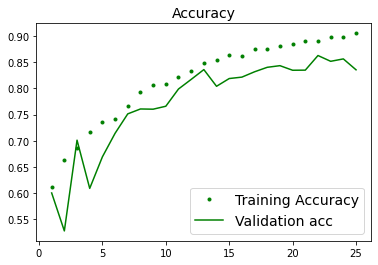

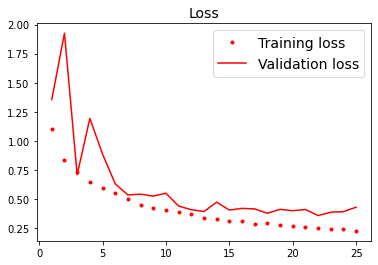

In [ ]:
#graphs of accuracy evolution
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()
##
# end = datetime.datetime.now()
# elapsed = end - startp
# print('Feature extraction method 2 took {} to execute.'.format(elapsed))
# elapsed = end - start
# print('Total running time of notebook thus far: {}'.format(elapsed))
# startp = datetime.datetime.now() # Set new start time for new process method

In [ ]:
plot_perf(history)

In [ ]:
#plot confusion matrix
actual = test_generator.labels
predicted = np.where(base_model.predict(test_generator)>0.5, 1, 0)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted)

# cm_display.plot()
plt.show()

Save the model out to google drive if desired.  

In [ ]:
if DRIVE_SAVE:
  base_model.save(DEEPFAKE_MODEL_SAVE_PATH+'MobileNet_TransferLearning_2')
# from tensorflow import keras
# model = keras.models.load_model(DEEPFAKE_MODEL_SAVE_PATH+'MobileNet_TransferLearning_2') 


OSError: ignored

## XCeption

Now let's try a popular model, XCeption, which has a nice balance of size and accuracy (with a little higher GPU time)

In [ ]:
tf.keras.backend.clear_session() #good to clear session between models

In [ ]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [ ]:
train_set_raw

<TensorSliceDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
#tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=RANDOM_SEED).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

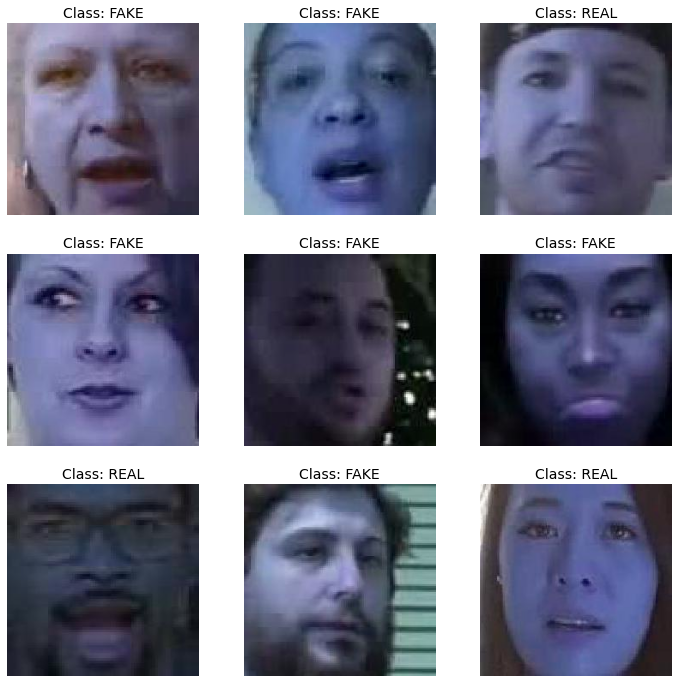

In [ ]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

Set up data augmentation using keras built in

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=RANDOM_SEED),
    tf.keras.layers.RandomRotation(factor=0.05, seed=RANDOM_SEED),
    #tf.keras.layers.RandomContrast(factor=0.2, seed=42) # random contrast seems to be making values go out of bounds
])

In [ ]:
#apply data augmentation to train_set
train_aug = train_set.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

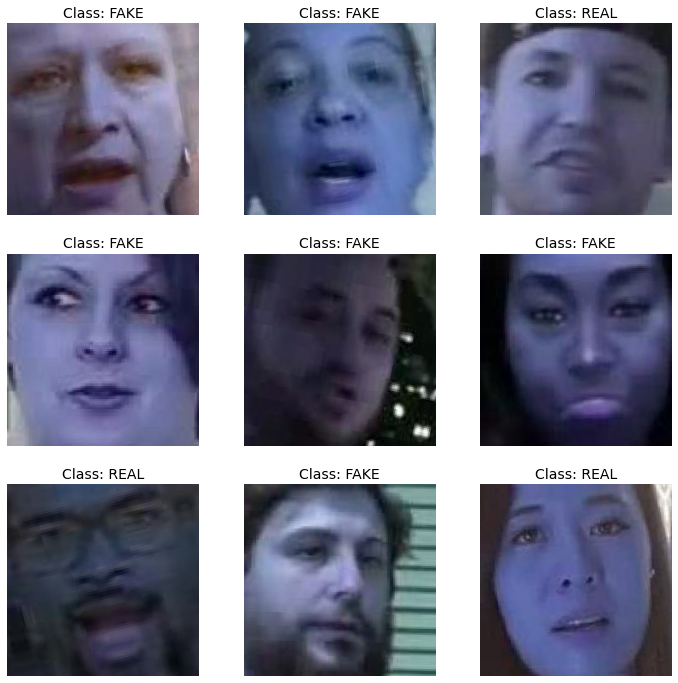

In [ ]:
# extra code – displays the same first 9 images, after augmentation

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

Now load the pretrained model without top layers.  We will replace them with our own customized layers for this project.

In [ ]:
# Set up Model
tf.random.set_seed(RANDOM_SEED)  #  ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

Set base model layers to non-trainable

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Train just the top layers for a few epochs

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_aug, validation_data=valid_set, epochs=8)

Epoch 1/8
560/560 [==============================] - 25s 39ms/step - loss: 0.7548 - accuracy: 0.5844 - val_loss: 0.7086 - val_accuracy: 0.6003
Epoch 2/8
560/560 [==============================] - 21s 38ms/step - loss: 0.7487 - accuracy: 0.6140 - val_loss: 0.6622 - val_accuracy: 0.6379
Epoch 3/8
560/560 [==============================] - 21s 38ms/step - loss: 0.7410 - accuracy: 0.6244 - val_loss: 0.6320 - val_accuracy: 0.6561
Epoch 4/8
560/560 [==============================] - 22s 38ms/step - loss: 0.7256 - accuracy: 0.6276 - val_loss: 0.6752 - val_accuracy: 0.6365
Epoch 5/8
560/560 [==============================] - 22s 38ms/step - loss: 0.7182 - accuracy: 0.6331 - val_loss: 0.8097 - val_accuracy: 0.5930
Epoch 6/8
560/560 [==============================] - 22s 38ms/step - loss: 0.7144 - accuracy: 0.6368 - val_loss: 0.6330 - val_accuracy: 0.6561
Epoch 7/8
560/560 [==============================] - 22s 38ms/step - loss: 0.7346 - accuracy: 0.6352 - val_loss: 0.7869 - val_accuracy: 0.6113

In [ ]:
if DRIVE_SAVE:
  model.save(DEEPFAKE_MODEL_SAVE_PATH+'xception_model_half2_2_23')
# from tensorflow import keras
# model = keras.models.load_model(DEEPFAKE_MODEL_SAVE_PATH+'xception_model_half2_2_23')

In [ ]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_3                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_10 67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_26                 68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_33                
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [ ]:
model.evaluate(test_set)

200/200 [==============================] - 4s 21ms/step - loss: 0.8556 - accuracy: 0.6016


[0.8556298017501831, 0.6015625]

Performance has increased now after just fine-tuning the top layers.  Let's unfreeze the entire model and train it more.  

NB: Learning rate is now decreased so as to not un-tune the pretrained base layers.

In [ ]:
for layer in base_model.layers[56:]:
    if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_aug, validation_data=valid_set, epochs=20)

Epoch 1/20
560/560 [==============================] - 35s 56ms/step - loss: 0.6743 - accuracy: 0.5731 - val_loss: 0.6731 - val_accuracy: 0.5418
Epoch 2/20
560/560 [==============================] - 31s 55ms/step - loss: 0.5772 - accuracy: 0.6943 - val_loss: 0.5345 - val_accuracy: 0.7357
Epoch 3/20
560/560 [==============================] - 31s 55ms/step - loss: 0.4986 - accuracy: 0.7533 - val_loss: 0.5747 - val_accuracy: 0.7284
Epoch 4/20
560/560 [==============================] - 31s 55ms/step - loss: 0.4378 - accuracy: 0.7918 - val_loss: 0.4191 - val_accuracy: 0.8077
Epoch 5/20
560/560 [==============================] - 31s 55ms/step - loss: 0.3829 - accuracy: 0.8214 - val_loss: 0.3858 - val_accuracy: 0.8335
Epoch 6/20
560/560 [==============================] - 31s 55ms/step - loss: 0.3395 - accuracy: 0.8430 - val_loss: 0.4189 - val_accuracy: 0.8147
Epoch 7/20
560/560 [==============================] - 31s 55ms/step - loss: 0.3062 - accuracy: 0.8653 - val_loss: 0.3820 - val_accuracy:

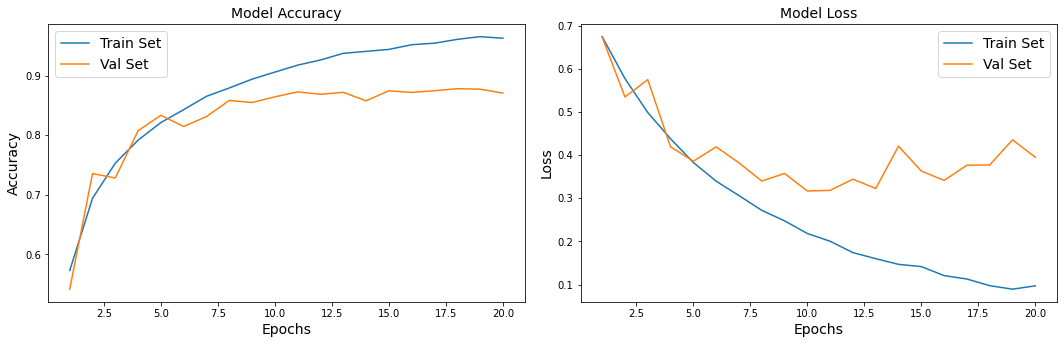

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
model.evaluate(test_set)

200/200 [==============================] - 4s 21ms/step - loss: 0.3743 - accuracy: 0.8775


[0.37430983781814575, 0.8774999976158142]

Accuracy has improved further.  

200/200 [==============================] - 4s 19ms/step


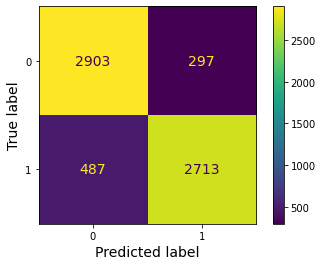

In [ ]:
#plot confusion matrix
actual=[]
for images, labels in test_set.unbatch():
    actual.append(labels.numpy())

predicted = np.where(model.predict(test_set)>0.5, 1, 0)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted)

# cm_display.plot()
plt.show()

In [ ]:
if DRIVE_SAVE:
  model.save(DEEPFAKE_MODEL_SAVE_PATH+'xception_model_2_2_23')

In [ ]:

# from tensorflow import keras
# model = keras.models.load_model(DEEPFAKE_MODEL_SAVE_PATH+'xception_model')

### Visual interpretability using Lime 

In [ ]:
#create lime image explainer
limesplainer = lime_image.LimeImageExplainer()



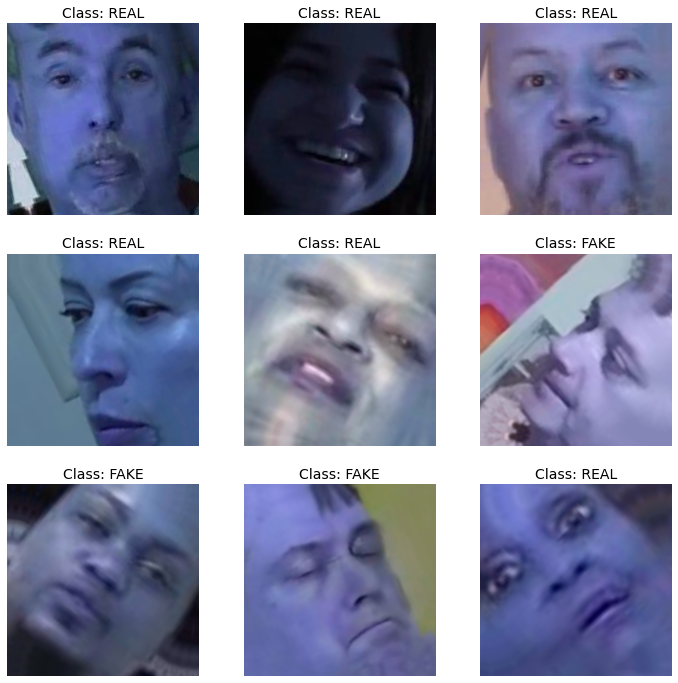

In [ ]:
# Take another look at some sample images.
plt.figure(figsize=(12, 12))
for x, y in test_set.take(1):
  for index in range(9):
      plt.subplot(3, 3, index + 1)
      x = data_augmentation(x, training=True)
      plt.imshow((x[index] + 1) / 2)  # rescale to 0–1 for imshow()
      if(y[index]==1):
          classt='FAKE'
      else:
          classt='REAL'
      plt.title(f"Class: {classt}")
      plt.axis("off")

plt.show()

In [ ]:
display(type(x[2]))
x[2].numpy().min(), x[2].numpy().max()

tensorflow.python.framework.ops.EagerTensor

(-0.79288334, 0.6227578)

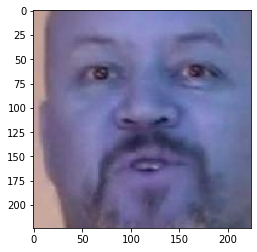

In [ ]:
plt.imshow((x[2] + 1) / 2)

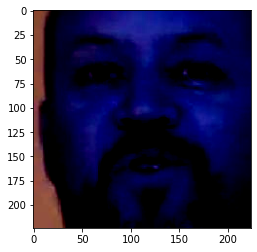

In [ ]:
plt.imshow((x[2]) /1)#this is what the raw bits look like, without fixing to imshow range 0-1

In [ ]:
#display shows in more real color, but imshow works in plt
display(Image(x[2]))

In [ ]:
pick = 2
test_data=x[pick,:,:,:]
test_data.shape


TensorShape([224, 224, 3])

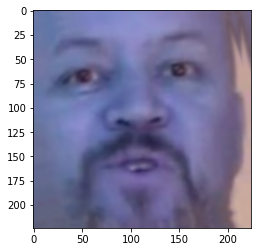

In [ ]:
plt.imshow((test_data + 1) / 2)

In [ ]:
test_data = test_data.numpy()#.astype(np.double)
test_data.shape

(224, 224, 3)

In [ ]:
#uncomment %%capture to suppress the 1000 lines of output
%%capture  
explanation = limesplainer.explain_instance(test_data.astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000);

(-0.5, 223.5, 223.5, -0.5)

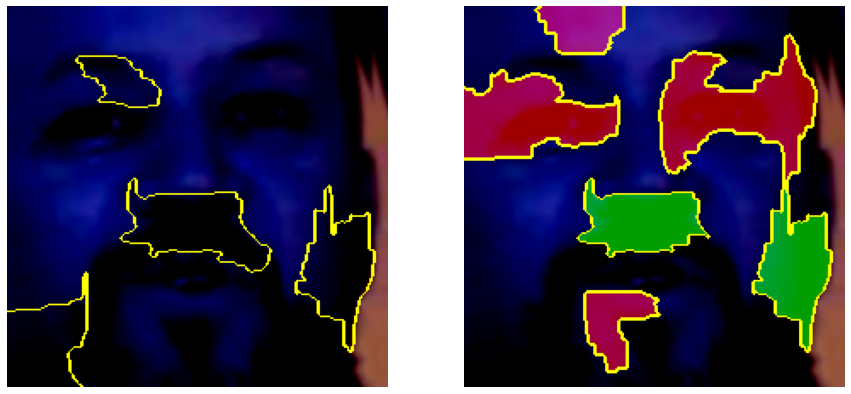

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')


In [ ]:
test_dataC = (test_data+1)/2

In [ ]:
#uncomment this to suppress the 1000 lines of output
%%capture  
explanation = limesplainer.explain_instance(((test_dataC)).astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000);

(-0.5, 223.5, 223.5, -0.5)

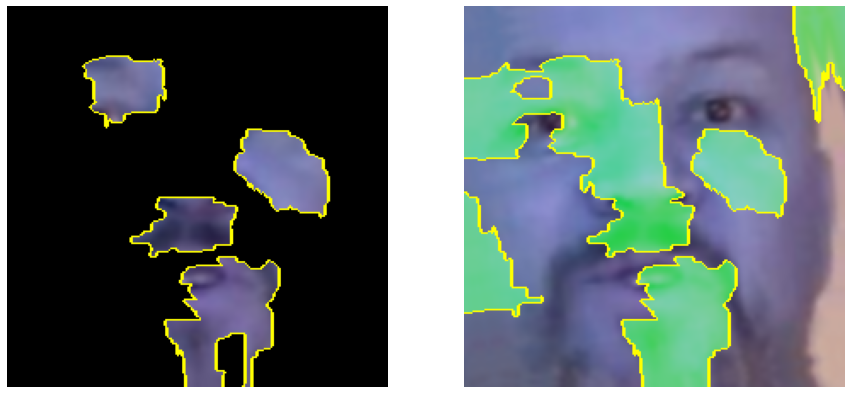

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')


### Visual interpretability using Grad-CAM  

Source, modified for this project: https://keras.io/examples/vision/grad_cam/

In [ ]:
# from tensorflow import keras
# model = keras.models.load_model(DEEPFAKE_MODEL_SAVE_PATH+'xception_model')

In [ ]:
#Inspect model summary - this process needs some understanding of where the conv layers are!
if SUMMARIZE:
  model.summary()

In [ ]:
# Inspect plot model for where the last convolutional layer is
if SUMMARIZE:
  keras.utils.plot_model(model, show_shapes=True)

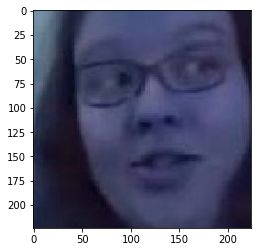

In [ ]:
#Set up some parameters for use below
img_size = img2dim #img2dim = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"


#Inspect our randomly chosen image
plt.imshow(cv2.imread(colab_link+'/faces_224/'+'gkwmalrvcj.jpg'))


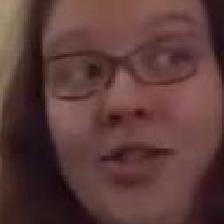

In [ ]:
#try a different way to display
import pathlib
img_path = pathlib.Path(colab_link+'/faces_224/'+'gkwmalrvcj.jpg') 
img_path
display(Image(img_path))

Define the Grad-CAM Algorithm

In [ ]:
def get_img_array(img_path, size):
    # `img` is a JPG image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3) ##IMG_SHAPE = (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Apply it on our test image

1/1 [==============================] - 0s 26ms/step
Predicted([[1]]): Fake


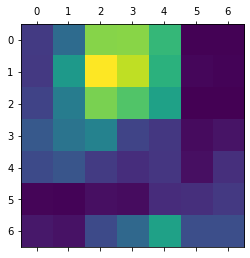

In [ ]:
# Prepare image
# img_array = preprocess_input(get_img_array(img_path, size=img_size))
# tf.cast(image, tf.float32)
img_array = preprocess_input(tf.cast(get_img_array(img_path, size=img_size), tf.float32))

# Make model
#model = model_builder(weights="imagenet", input_shape = IMG_SHAPE)

# Remove last layer's softmax
#model.layers[-1].activation = None #not needed here, we don't need or want postprocessing

# Print what the top predicted class is
preds = np.where(model.predict(img_array)>0.5, 1, 0)
# print("Predicted:", decode_predictions(preds, top=1)[0]) #not needed here, we don't need or want postprocessing
print(f"Predicted({preds}):", "Fake" if preds==1 else "Real")

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Superimpose heatmap over original image

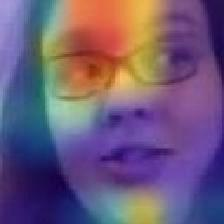

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

Let's try it for a few other images.

1/1 [==============================] - 0s 26ms/step
Actual:FAKE Predicted(1): Fake


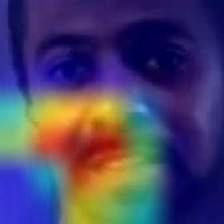

1/1 [==============================] - 0s 22ms/step
Actual:REAL Predicted(0): Real


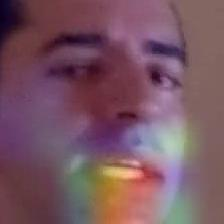

1/1 [==============================] - 0s 21ms/step
Actual:FAKE Predicted(0): Real


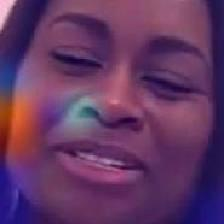

1/1 [==============================] - 0s 24ms/step
Actual:FAKE Predicted(1): Fake


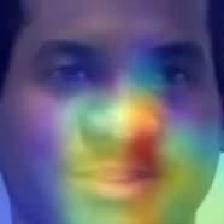

1/1 [==============================] - 0s 21ms/step
Actual:FAKE Predicted(1): Fake


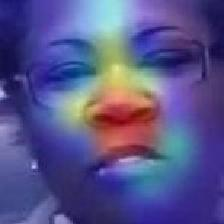

1/1 [==============================] - 0s 21ms/step
Actual:FAKE Predicted(0): Real


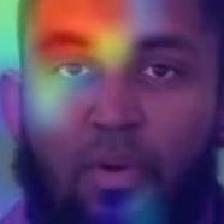

1/1 [==============================] - 0s 21ms/step
Actual:REAL Predicted(0): Real


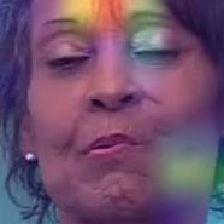

1/1 [==============================] - 0s 21ms/step
Actual:REAL Predicted(0): Real


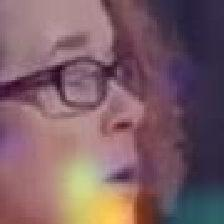

1/1 [==============================] - 0s 22ms/step
Actual:FAKE Predicted(0): Real


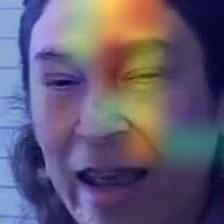

In [ ]:
#Try it for a few other images:
for i, (_, label, filename) in enumerate(Val_set[['label', 'jpg_filename']].sample(9).itertuples()):#random_state=RANDOM_SEED)):
    #print(i, label, filename)
    img_path = pathlib.Path(colab_link+'/faces_224/'+filename)
    # # Prepare image
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    img_array = tf.cast(img_array,tf.float32)
    # img_array = preprocess_input(tf.cast(get_img_array(img_path, size=img_size), tf.float32))

    # Print what the two top predicted classes are
    preds = int(np.where(model.predict(img_array)>0.5, 1, 0))
    print(f"Actual:{label} "+f"Predicted({preds}):", "Fake" if preds==1 else "Real")
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=0)
    save_and_display_gradcam(img_path, heatmap)


## EfficientNetB0

EfficientNetB0 has one of the highest accuracy on Keras website, but isn't quite as massive as V2L

In [124]:
tf.keras.backend.clear_session() #good to clear session between models

In [125]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

21834768/21834768 [==============================] - 0s 0us/step


In [126]:
if SUMMARIZE:
  model.summary()

In [127]:
#If extra regularization is needed, try this
#model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.3) #default is 0.2, going for a little more regularization than that.


In [142]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))




In [143]:
train_set_raw.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [144]:
batch_size = 64
# preprocess = tf.keras.applications.xception.preprocess_input
# train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
# train_set = train_set.shuffle(1000, seed=RANDOM_SEED).batch(batch_size).prefetch(1)
# valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
# test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)



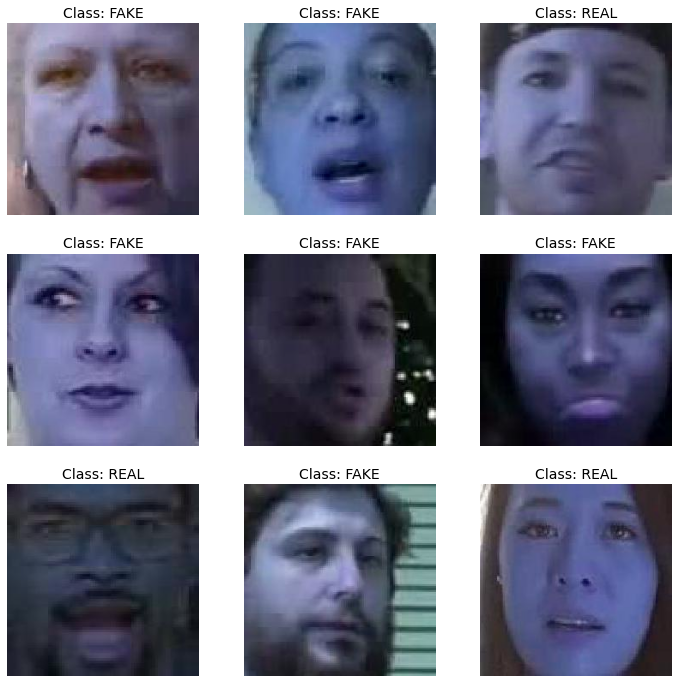

In [ ]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [ ]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.10),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        #layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

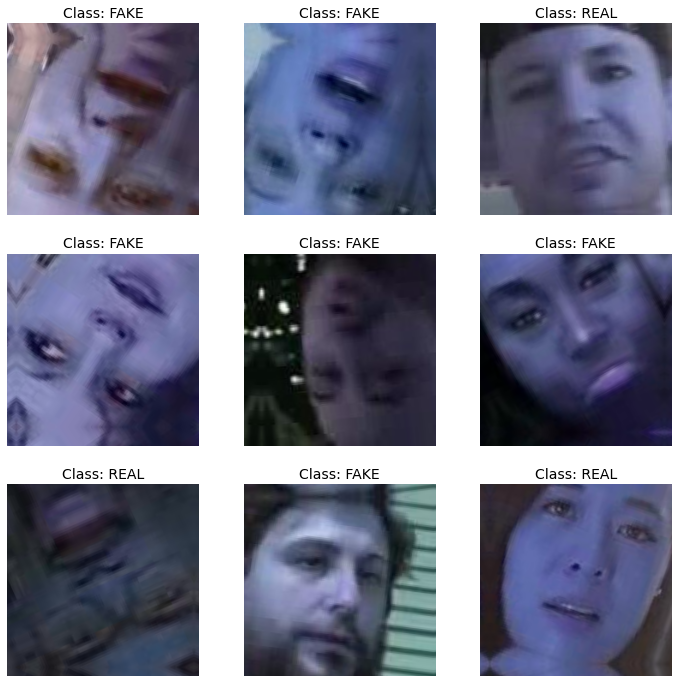

In [ ]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_aug = img_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        img = (X_batch_aug[index] + 1) / 2
        plt.imshow(img)
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [145]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

ds_train = train_set_raw
ds_test = test_set_raw
ds_valid = valid_set_raw
ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_valid = ds_valid.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_test = ds_test.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)

ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_valid = ds_valid.batch(batch_size=batch_size, drop_remainder=True)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)
#ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 10  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_valid, verbose=2)

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


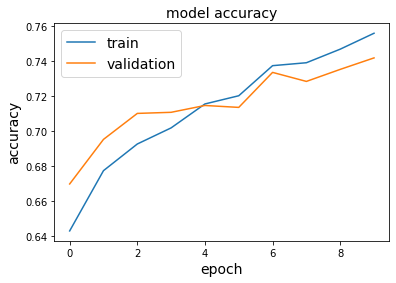

In [ ]:
plot_hist(hist)

In [ ]:
plot_perf(hist)

This works pretty well - let's freeze it, train our final layers, then unfreeze and fine-tune

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Epoch 1/30


280/280 - 157s - loss: 1.1021 - accuracy: 0.5718 - val_loss: 0.6636 - val_accuracy: 0.6105 - 157s/epoch - 561ms/step
Epoch 2/30
280/280 - 147s - loss: 0.8524 - accuracy: 0.5903 - val_loss: 0.8067 - val_accuracy: 0.5598 - 147s/epoch - 526ms/step
Epoch 3/30
280/280 - 149s - loss: 0.7415 - accuracy: 0.6029 - val_loss: 0.9933 - val_accuracy: 0.5334 - 149s/epoch - 533ms/step
Epoch 4/30
280/280 - 149s - loss: 0.6893 - accuracy: 0.6095 - val_loss: 0.7186 - val_accuracy: 0.5562 - 149s/epoch - 532ms/step
Epoch 5/30
280/280 - 148s - loss: 0.6620 - accuracy: 0.6210 - val_loss: 0.6638 - val_accuracy: 0.6020 - 148s/epoch - 529ms/step
Epoch 6/30
280/280 - 148s - loss: 0.6562 - accuracy: 0.6214 - val_loss: 0.6746 - val_accuracy: 0.5911 - 148s/epoch - 527ms/step
Epoch 7/30
280/280 - 148s - loss: 0.6490 - accuracy: 0.6299 - val_loss: 0.6705 - val_accuracy: 0.6019 - 148s/epoch - 528ms/step
Epoch 8/30
280/280 - 148s - loss: 0.6509 - accuracy: 0.6254 - val_loss: 0.6717 - val_accuracy: 0.5975 - 148s/epoch 

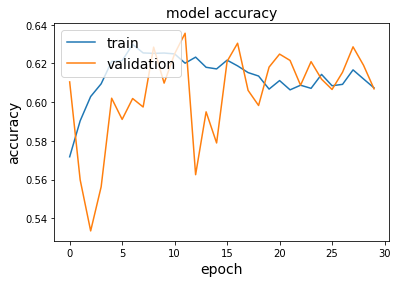

In [ ]:
# with strategy.scope():
#     model = build_model(num_classes=NUM_CLASSES)
model = build_model(num_classes=NUM_CLASSES)

epochs = 30  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

In [ ]:
# save model
if DRIVE_SAVE:
  model.save(DEEPFAKE_MODEL_SAVE_PATH+'EffNetB0half_1_31_23b')
# from tensorflow import keras
# model = keras.models.load_model(DEEPFAKE_MODEL_SAVE_PATH+'EffNetB0half_1_31_23')

Epoch 1/50


280/280 - 168s - loss: 0.6208 - accuracy: 0.6523 - val_loss: 0.5961 - val_accuracy: 0.6867 - 168s/epoch - 600ms/step
Epoch 2/50
280/280 - 164s - loss: 0.5873 - accuracy: 0.6869 - val_loss: 0.5776 - val_accuracy: 0.6955 - 164s/epoch - 586ms/step
Epoch 3/50
280/280 - 160s - loss: 0.5646 - accuracy: 0.7033 - val_loss: 0.5859 - val_accuracy: 0.6958 - 160s/epoch - 572ms/step
Epoch 4/50
280/280 - 161s - loss: 0.5460 - accuracy: 0.7185 - val_loss: 0.5465 - val_accuracy: 0.7216 - 161s/epoch - 575ms/step
Epoch 5/50
280/280 - 157s - loss: 0.5275 - accuracy: 0.7304 - val_loss: 0.6322 - val_accuracy: 0.6659 - 157s/epoch - 562ms/step
Epoch 6/50
280/280 - 156s - loss: 0.5068 - accuracy: 0.7486 - val_loss: 0.5259 - val_accuracy: 0.7319 - 156s/epoch - 558ms/step
Epoch 7/50
280/280 - 156s - loss: 0.4974 - accuracy: 0.7511 - val_loss: 0.5095 - val_accuracy: 0.7436 - 156s/epoch - 556ms/step
Epoch 8/50
280/280 - 161s - loss: 0.4868 - accuracy: 0.7588 - val_loss: 0.4957 - val_accuracy: 0.7541 - 161s/epoch 

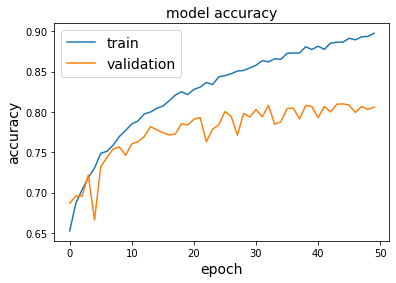

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 50  # @param {type: "slider", min:8, max:50}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

In [150]:
# save model
if DRIVE_SAVE:
  model.save(DEEPFAKE_MODEL_SAVE_PATH+'EffNetB0_1_31_23_v2')
# from tensorflow import keras
# model = keras.models.load_model(DEEPFAKE_MODEL_SAVE_PATH+'EffNetB0_1_31_23_v2')

In [ ]:
# plot_perf(history)

In [160]:
model.evaluate(ds_test)

100/100 [==============================] - 4s 24ms/step - loss: 0.4237 - accuracy: 0.8059


[0.42369598150253296, 0.8059375286102295]

In [134]:
actual=[]
for images, labels in ds_test.unbatch():
    #actual.append(labels.numpy())
    #print(labels.numpy()[1])
    #actual.append(labels.numpy)
    act = 1 if labels.numpy()[1] == 1.0 else 0
    actual.append(act)
actual = np.array(actual)

100/100 [==============================] - 2s 22ms/step


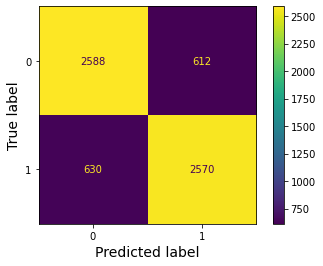

In [159]:
#plot confusion matrix
# predicted_multi = np.where(model.predict(ds_test)>0.5, 1, 0)
pred = model.predict(ds_test)
predicted = np.argmax(pred,1)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted)

# cm_display.plot()
plt.show()

## EfficientNetV2L 

EfficientNetV2L has among the highest accuracy ratings on Keras's website.  Let's give it a try.

In [167]:
tf.keras.backend.clear_session() #good to clear session between models

In [168]:
# tf.keras.applications.EfficientNetV2L(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
#     include_preprocessing=True,
# )

In [169]:
input_shape=[224, 224, 3]
image_size = 224
#re-import in case we begin here
import os
import tensorflow as tf
from tensorflow import keras
import numpy

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest'
                                   )

train_generator = train_datagen.flow_from_dataframe(dataframe=pd.DataFrame(Train_set), 
                                                    x_col='jpg_filename', y_col='label', 
                                                    directory=colab_faces,
                                                    target_size=(image_size, image_size),  
                                                    batch_size= 20, 
                                                    class_mode= 'binary')




Found 17920 validated image filenames belonging to 2 classes.


In [170]:
# # Get all the data in the directory split/validation (200 images), and reshape them
val_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest'
                                   )
val_generator = val_datagen.flow_from_dataframe(dataframe=pd.DataFrame(Val_set), 
                                                    x_col='jpg_filename', y_col='label', 
                                                    directory=colab_faces,
                                                    target_size=(image_size, image_size),  
                                                    batch_size= 20, 
                                                    class_mode= 'binary')

Found 7680 validated image filenames belonging to 2 classes.


In [171]:
# # Get all the data in the directory split/test (180 images), and reshape them
test_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest'
                                   )
test_generator = test_datagen.flow_from_dataframe(dataframe=pd.DataFrame(Test_set), 
                                                    x_col='jpg_filename', y_col='label', 
                                                    directory=colab_faces,
                                                    target_size=(image_size, image_size),  
                                                    batch_size= 20, 
                                                    class_mode= 'binary', shuffle=False)

Found 6400 validated image filenames belonging to 2 classes.


In [ ]:
## To see a summary of architecture of the full model, uncomment this.  Not currently used - see following cells for customized model
# base_model = tf.keras.applications.EfficientNetV2L()
# if SUMMARIZE:
#   base_model.summary()

In [ ]:
## can run this cell to verify that we are setting base layers to non-trainable
# base_model = tf.keras.applications.EfficientNetV2L(input_shape=input_shape, include_top=False)
# base_model.trainable = False
# #include_top removes top layer
# if SUMMARIZE:
#   base_model.summary()

We need a version of the model with no top layer, and customize our own layer.

In [ ]:
#adding new dense layers - add final layer that classifies either as fake or real
IMG_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetV2L(input_shape=IMG_SHAPE, include_top=False)
base_model.trainable = False

base_model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dropout(.3),
  keras.layers.Dense(1, activation='sigmoid')
])

if SUMMARIZE:
  base_model.summary()

#these new layers should be trainable by default, but can switch trainability by
# base_model.layers[n].trainable = True


473176280/473176280 [==============================] - 4s 0us/step


In order to balance out batch size/runtime/learning rates, I investigate using a LearningRateScheduler.

In [ ]:
# Time based decay scheduler:
# initial_learning_rate = 1E-2
# epochs = 20
# decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)
# history_time_based_decay = model.fit(
#     X_train, 
#     y_train, 
#     epochs=epochs, 
#     validation_split=0.2,
#     batch_size=64,
#     callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)],
# )

In [ ]:
# exponential LR decay scheduler
initial_learning_rate = 1E-2
def lr_exp_decay(epoch, lr):
    # k = 0.5
    return initial_learning_rate * np.exp(-k*epoch)
# Fit the model to the training data
# history_exp_decay = model.fit(
#     X_train, 
#     y_train, 
#     epochs=epochs, 
#     validation_split=0.2,
#     batch_size=64,
#     callbacks=[LearningRateScheduler(lr_exp_decay, verbose=1)],
# )

In [ ]:
# Compile the model
learning_rate = 1E-2
#momentum=0.9#to use or not to use
# base_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
base_model.compile(optimizer=tf.keras.optimizers.Nadam(),
              #      RMSprop(learning_rate=learning_rate, momentum=momentum),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Fit the model
epochs = 25
batch_size = 32 
steps_per_epoch = numpy.ceil(train_generator.n / batch_size)
validation_steps = numpy.ceil(val_generator.n / batch_size)

#params for lr schedulers
initial_learning_rate = learning_rate
epochs = epochs
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)
#
finalLR = 1E-3
totalexpdecay=finalLR/initial_learning_rate
k = -np.log(totalexpdecay)/epochs #0.5
def lr_exp_decay(epoch, lr):
    return initial_learning_rate * np.exp(-k*epoch)

history = base_model.fit(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              callbacks=[LearningRateScheduler(lr_exp_decay, verbose=1)]
                         )


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/25


InternalError: ignored

In [ ]:
report_acc(base_model)

In [ ]:
# save model
if DRIVE_SAVE:
  base_model.save(DEEPFAKE_MODEL_SAVE_PATH+'EfficientNetV2L_halfway_1-30-23')


In [ ]:
## If necessary, load model
# from tensorflow import keras
# base_model = keras.models.load_model(DEEPFAKE_MODEL_SAVE_PATH+'EfficientNetV2L_halfway')

Next, need to train top layer with high learning rate, then unfreeze base and retrain with lower LR.

In [ ]:
#unfreeze main model
# for layer in base_model.layers[71:]: #layer 70 is the end of a block
#     layer.trainable = True

for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

if SUMMARIZE:
  base_model.summary()
#recompile with lower LR
learning_rate = 1E-3
momentum = 0.9
base_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate, momentum=momentum),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#refit model
epochs = 10#20
batch_size = 32
steps_per_epoch = np.ceil(train_generator.n / batch_size)
validation_steps = np.ceil(val_generator.n / batch_size)

#params for lr schedulers
initial_learning_rate = learning_rate
epochs = epochs
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)
#
finalLR = 1E-4
totalexpdecay=finalLR/initial_learning_rate
k = -np.log(totalexpdecay)/epochs #0.5
def lr_exp_decay(epoch, lr):
    return initial_learning_rate * np.exp(-k*epoch)

history = base_model.fit(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              callbacks=[LearningRateScheduler(lr_exp_decay, verbose=1)]                         
                         )

In [ ]:
report_acc(base_model)

In [ ]:
#graphs of accuracy evolution
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()
##
# end = datetime.datetime.now()
# elapsed = end - startp
# print('Feature extraction method 2 took {} to execute.'.format(elapsed))
# elapsed = end - start
# print('Total running time of notebook thus far: {}'.format(elapsed))
# startp = datetime.datetime.now() # Set new start time for new process method

In [ ]:
# save model
if DRIVE_SAVE:
  base_model.save(DEEPFAKE_MODEL_SAVE_PATH+'EfficientNetV2L_TransferLearning_2_2_4')
# from tensorflow import keras
# base_model = keras.models.load_model(DEEPFAKE_MODEL_SAVE_PATH+'EfficientNetV2L_TransferLearning_1_1-30-23')

In [164]:
from tensorflow import keras
base_model = keras.models.load_model(DEEPFAKE_MODEL_SAVE_PATH+'EfficientNetV2L_TransferLearning_1')

In [ ]:
plot_perf(history)

In [173]:
predicted = np.where(base_model.predict(test_generator)>0.5, 1, 0)

320/320 [==============================] - 70s 219ms/step


In [174]:
predicted

array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

320/320 [==============================] - 69s 217ms/step


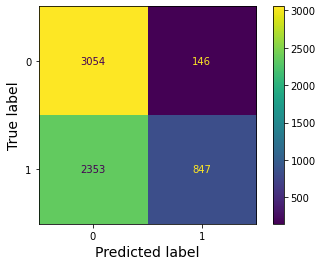

In [175]:
actual = test_generator.labels

predicted = np.where(base_model.predict(test_generator)>0.5, 1, 0)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted)

# cm_display.plot()
plt.show()

In [176]:
base_model.evaluate(test_generator)

320/320 [==============================] - 75s 217ms/step - loss: 0.6737 - accuracy: 0.6062


[0.6736798882484436, 0.606249988079071]

# Conclusion and Results

Confusion Matrix for Baseline model with test set accuracy: 76.7%

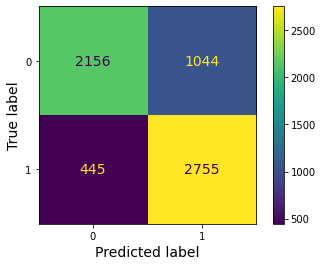

CM for VGG19 with test accuracy: 64%

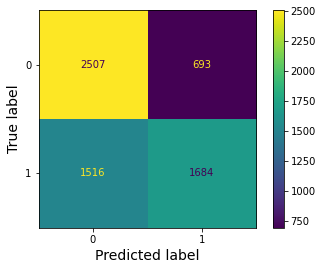

CM for Mobile net with test accuracy: 67%

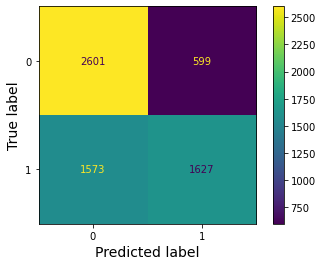

CM for XCeption with test accuracy: 87.8%

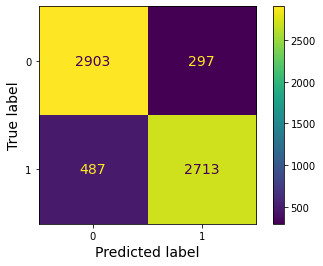

CM for EfficientNetB0 with test accuracy: 80.6%

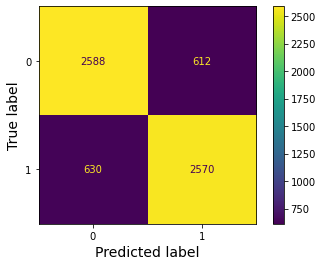

CM for EfficientetV2L with test accuracy: 60.6%

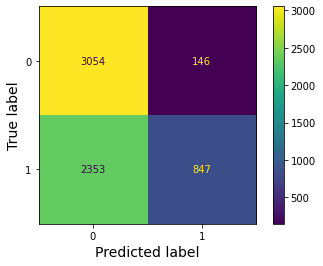

# ideas: use gridsearch to try different learning rates?
# add momentum as well as LR to optimizers

# confusion matrix for final result

#compare evaluation times for different models too?
# in order to justify possibly using different models in different settings

#Try grad-cam instead of lime?
https://towardsdatascience.com/generalizing-your-model-an-example-with-efficientnetv2-and-cats-dogs-6903740dfe2c


https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6

